<a href="https://colab.research.google.com/github/Pt-home/Dodgem/blob/main/Dodgem_Updated_With_Draw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 🎮 Dodgem — універсальна версія з вибором розміру дошки

import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json

In [18]:
# 🧩 Налаштування
board_size = 5  # ← Можна змінити на 3, 5, 6...

games_to_play = 100000
learning_rate = 0.1
epsilon = 0.1

In [19]:
# 🚀 Початкова конфігурація відповідно до розміру
def initial_state():
    x_pieces = [(0, i) for i in range(board_size - 1)]
    y_pieces = [(i, board_size - 1) for i in range(1, board_size)]
    return (x_pieces, y_pieces, 'X')

# 🧠 Генерація можливих ходів
def get_legal_moves(state):
    x_pieces, y_pieces, turn = state
    occupied = set(p for p in x_pieces + y_pieces if p != 'out')
    legal = []

    if turn == 'X':
        for i, pos in enumerate(x_pieces):
            if pos == 'out': continue
            x, y = pos
            if x == board_size - 1:
                legal.append((i, 'exit'))
            if (x+1, y) not in occupied and x+1 < board_size:
                legal.append((i, 'right'))
            if (x, y+1) not in occupied and y+1 < board_size:
                legal.append((i, 'down'))
    else:
        for i, pos in enumerate(y_pieces):
            if pos == 'out': continue
            x, y = pos
            if y == 0:
                legal.append((i, 'exit'))
            if (x-1, y) not in occupied and x-1 >= 0:
                legal.append((i, 'left'))
            if (x, y-1) not in occupied and y-1 >= 0:
                legal.append((i, 'up'))
    return legal

# ⬆⬇ Застосування ходу
def apply_move(state, move):
    x_pieces, y_pieces, turn = state
    x_pieces = x_pieces[:]
    y_pieces = y_pieces[:]
    i, direction = move

    if turn == 'X':
        if direction == 'exit':
            x_pieces[i] = 'out'
        else:
            x, y = x_pieces[i]
            if direction == 'right': x_pieces[i] = (x+1, y)
            elif direction == 'down': x_pieces[i] = (x, y+1)
        return (x_pieces, y_pieces, 'Y')
    else:
        if direction == 'exit':
            y_pieces[i] = 'out'
        else:
            x, y = y_pieces[i]
            if direction == 'left': y_pieces[i] = (x-1, y)
            elif direction == 'up': y_pieces[i] = (x, y-1)
        return (x_pieces, y_pieces, 'X')

# Перевірка завершення гри
def is_terminal(state):
    return all(p == 'out' for p in state[0]) or all(p == 'out' for p in state[1])

# Переможець
def winner(state):
    x_done = all(p == 'out' for p in state[0])
    y_done = all(p == 'out' for p in state[1])
    if x_done and not y_done: return 'X'
    if y_done and not x_done: return 'Y'
    return None

In [20]:
# Q-таблиця для навчання
q_table = {'X': defaultdict(lambda: defaultdict(lambda: 1.0)),
           'Y': defaultdict(lambda: defaultdict(lambda: 1.0))}

In [ ]:
# 🔁 Завантаження Q-таблиці - при потребі
def load_qtable(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    q = {'X': defaultdict(lambda: defaultdict(lambda: 1.0)),
         'Y': defaultdict(lambda: defaultdict(lambda: 1.0))}
    for player in data:
        for state in data[player]:
            for move, value in data[player][state].items():
                move_tuple = eval(move)
                q[player][state][move_tuple] = value
    return q

# q_table = load_qtable("Q_Dodgem_4x4_G50000_lr0.1_eps0.1.json")

In [21]:
# Вибір ходу
def choose_move(player, state):
    legal = get_legal_moves(state)
    if not legal:
        return None
    if random.random() < epsilon:
        return random.choice(legal)
    weights = q_table[player][str(state)]
    weighted = [(m, weights[m]) for m in legal]
    total = sum(w for _, w in weighted)
    if total <= 0:
        return random.choice(legal)
    probs = [w / total for _, w in weighted]
    return random.choices([m for m, _ in weighted], probs)[0]

# Симуляція гри
def play_game():
    state = initial_state()
    trajectory = []

    while not is_terminal(state):
        player = state[2]
        legal = get_legal_moves(state)
        if not legal:
            # Блокування = програш для поточного гравця
            return 'Y' if player == 'X' else 'X', trajectory

        move = choose_move(player, state)
        if move is None:
            return 'Y' if player == 'X' else 'X', trajectory

        trajectory.append((player, str(state), move))
        state = apply_move(state, move)

        # --- Перевірка на нічийну ситуацію ---
        # Якщо X вивів усі фішки — дамо Y один додатковий хід
        if is_terminal(state):
            winner_now = winner(state)
            if winner_now == 'X':
                y_remaining = any(p != 'out' for p in state[1])
                if y_remaining:
                    # Додатковий хід для Y
                    legal_y = get_legal_moves(state)
                    if legal_y:
                        move_y = choose_move('Y', state)
                        if move_y:
                            trajectory.append(('Y', str(state), move_y))
                            state = apply_move(state, move_y)
                        # Перевірка: чи Y теж завершив
                        if all(p == 'out' for p in state[1]):
                            return 'Draw', trajectory
                        else:
                            return 'X', trajectory
            elif winner_now == 'Y':
                return 'Y', trajectory

    return winner(state), trajectory
# Навчання
def train(n):
    wins = Counter()
    for i in range(1, n + 1):
        result, path = play_game()
        wins[result] += 1
        for player, state_str, move in path:
            if result == 'Draw':
                reward = 0.5  # Нічия — часткова нагорода
            else:
                reward = 1 if result == player else 0
            q_table[player][state_str][move] += learning_rate * (reward - q_table[player][state_str][move])

        if i % 100000 == 0:
            total = sum(wins.values())
            print(f"After {i} games:", ', '.join(
                [f"{p} = {wins[p]} ({100 * wins[p]/total:.1f}%)" for p in ['X', 'Y', 'Draw'] if p in wins]))

    return wins



In [22]:
results = train(games_to_play)
print(f"🏁 Results after training on {board_size}×{board_size} board:", results)


After 100000 games: X = 40705 (40.7%), Y = 43679 (43.7%), Draw = 15616 (15.6%)
🏁 Results after training on 5×5 board: Counter({'Y': 43679, 'X': 40705, 'Draw': 15616})


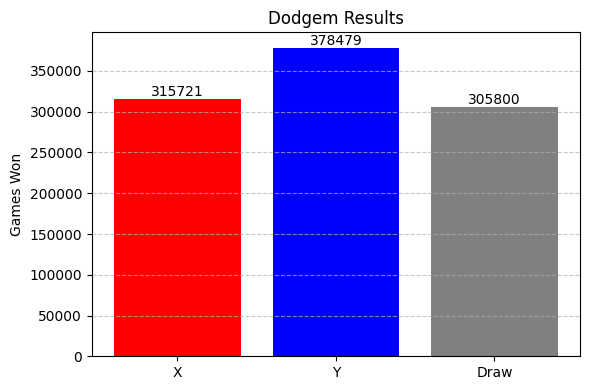

In [16]:
# 📊 Графік
def plot_results(results, title="Dodgem Results"):
    labels = ['X', 'Y', 'Draw']
    colors = ['red', 'blue', 'gray']
    values = [results.get(k, 0) for k in labels]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=colors)
    plt.title(title)
    plt.ylabel("Games Won")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_results(results)

In [17]:
# 📁 Формування унікального імені файлу
q_filename = f"Q_Dodgem_With_Draw_{board_size}x{board_size}_G{games_to_play}_lr{learning_rate}_eps{epsilon}.json"

# 🔄 Підготовка структури для збереження
def convert_qtable_to_serializable(qtable):
    serializable = {}
    for player in qtable:
        serializable[player] = {}
        for state, moves in qtable[player].items():
            serializable[player][state] = {str(k): v for k, v in moves.items()}
    return serializable

# 💾 Зберігання
with open(q_filename, "w") as f:
    json.dump(convert_qtable_to_serializable(q_table), f)

print(f"✅ Q-table saved to file: {q_filename}")

✅ Q-table saved to file: Q_Dodgem_With_Draw_4x4_G1000000_lr0.1_eps0.1.json
